# Lab 7

## Q1

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor as RFR
import matplotlib.pyplot as plt

In [3]:
#Code provided
columns = 'age gender bmi map tc ldl hdl tch ltg glu'.split()
diabetes = load_diabetes() 
df = pd.DataFrame(diabetes.data, columns=columns)
y = diabetes.target 

Now we will fit the random forest model and plot the feature importances.

In [4]:
model = RFR(random_state = 310, max_depth = 10, n_estimators = 1000)
df = pd.get_dummies(df)
model.fit(df,y)

RandomForestRegressor(max_depth=10, n_estimators=1000, random_state=310)

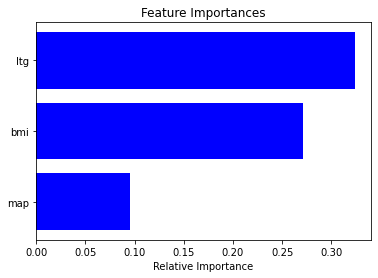

In [5]:
features = df.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-3:]  # top 3 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Our top 3 features are ltg, bmi, and map.

## Q2

First we will reset from using dummy variables.

In [6]:
df = pd.DataFrame(diabetes.data, columns=columns)

This is the stewise regression function we had in class.

In [7]:
# Implementation of stepwise regression
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details """
    #import necessary for the function
    import statsmodels.api as sm
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [8]:
stepwise_selection(df, y, [], .001, .001)

Add  bmi                            with p-value 3.46601e-42
Add  ltg                            with p-value 3.03968e-20
Add  map                            with p-value 3.74192e-05


<ipython-input-7-ee288d7d333a>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-7-ee288d7d333a>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-7-ee288d7d333a>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-7-ee288d7d333a>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


['bmi', 'ltg', 'map']

The remaining variables are bmi, ltg, and map.

## Q3

In [9]:
# Scaling and elastic net imports
from sklearn import linear_model as lm
from sklearn.preprocessing import StandardScaler

# Scaling and fitting the data
scale = StandardScaler()
dfs = scale.fit_transform(df)
model = lm.ElasticNet(alpha=0.1,l1_ratio = 0.5)
model.fit(dfs,y)

ElasticNet(alpha=0.1)

We can read the variables from the dataset directly to compare coefficients, as the order will be maintained.

In [10]:
model.coef_

array([ -0.06450966, -10.44169752,  24.131291  ,  14.75251583,
        -6.39435385,  -1.73433665,  -8.41018002,   5.20382877,
        22.94137958,   3.72439119])

The largest coefficents (in decreasing order) are 3, 9, and 4.

In [11]:
df

,age,gender,bmi,map,tc,ldl,hdl,tch,ltg,glu
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930


The correspending variables are bmi, ltg, and map.

## Q4

Using k-fold cross validation can provide us with a metric for the effectiveness of a model at a certain hyperparameter levels, by giving an average test MSE. Comparing this metric at different hyperparameter levels can hint at an ideal value for that given model.

## Q5

In [12]:
#First import the dataset and k-fold validation libraries
from sklearn.datasets import load_breast_cancer as lbc
from sklearn.model_selection import KFold

data = lbc()
X = pd.DataFrame(data = data.data, columns = data.feature_names)
y = data.target
X = X[['mean radius','mean texture']]

In [13]:
# This function is taken from work done in DATA 146; used to perform k-fold cross validation in one function
def DoKFold(model,X,y,k,random_state=1693,scaler=None):
    '''Function will perform K-fold validation and return a list of K training and testing scores, inclduing R^2 as well as MSE.
    
        Inputs:
            model: An sklearn model with defined 'fit' and 'score' methods
            X: An N by p array containing the features of the model.  The N Columns are features, and the p rows are observations.
            y: An array of length N containing the target of the model
            k: The number of folds to split the data into for K-fold validation
            random_state: used when splitting the data into the K folds (default=146)
            scaler: An sklearn feature scaler.  If none is passed, no feature scaling will be performed
        Outputs:
            train_scores: A list of length K containing the training scores
            test_scores: A list of length K containing the testing scores
            train_mse: A list of length K containing the MSE on training data
            test_mse: A list of length K containing the MSE on testing data
    '''
    
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=k,shuffle=True,random_state=random_state)
    
    train_scores=[]
    test_scores=[]
    train_mse=[]
    test_mse=[]
    
    for idxTrain, idxTest in kf.split(X):
        Xtrain = X.values[idxTrain]
        Xtest = X.values[idxTest]
        ytrain = y[idxTrain]
        ytest = y[idxTest]
        
        if scaler != None:
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)
        
        model.fit(Xtrain,ytrain)
        
        train_scores.append(model.score(Xtrain,ytrain))
        test_scores.append(model.score(Xtest,ytest))
        
        # Compute the mean squared errors
        ytrain_pred = model.predict(Xtrain)
        ytest_pred = model.predict(Xtest)
        train_mse.append(np.mean((ytrain-ytrain_pred)**2))
        test_mse.append(np.mean((ytest-ytest_pred)**2))
        
    return train_scores,test_scores,train_mse,test_mse

In [14]:
from sklearn.tree import DecisionTreeRegressor as DTR
leaf_range = np.arange(1, 25, 1)
depth_range = np.arange(1, 100, 1)
train = []
test = []
train_mse = []
test_mse = []
for i in depth_range:
    dtr = DTR(max_depth = i, min_samples_leaf = 10, random_state = 1693) # 10 is arbitrary, seems appropriate
    tr,te,msetr,msete = DoKFold(dtr, X, y, 10)
    train.append(np.mean(tr))
    test.append(np.mean(te))
    train_mse.append(np.mean(msetr))
    test_mse.append(np.mean(msete))

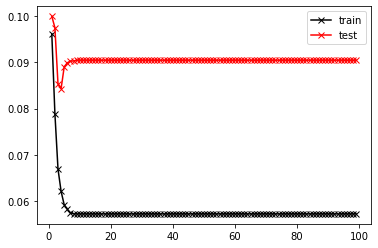

In [15]:
plt.plot(depth_range,train_mse, '-xk',label = 'train')
plt.plot(depth_range,test_mse,'-xr',label = 'test')
plt.legend()
plt.show()

The minimum seems to be in the first 10 values. We will check again in that range.

In [16]:
leaf_range = np.arange(1, 25, 1)
depth_range = np.arange(1, 10, 1)
train = []
test = []
train_mse = []
test_mse = []
for i in depth_range:
    dtr = DTR(max_depth = i, min_samples_leaf = 10, random_state = 1693) # 10 is arbitrary, seems appropriate
    tr,te,msetr,msete = DoKFold(dtr, X, y, 10)
    train.append(np.mean(tr))
    test.append(np.mean(te))
    train_mse.append(np.mean(msetr))
    test_mse.append(np.mean(msete))

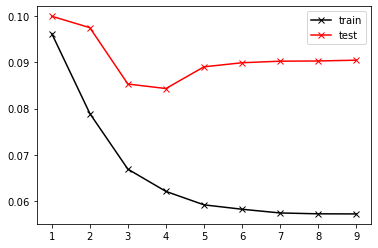

In [17]:
plt.plot(depth_range,train_mse, '-xk',label = 'train')
plt.plot(depth_range,test_mse,'-xr',label = 'test')
plt.legend()
plt.show()

The ideal depth seems to be 4. Now we will check minimum samples at this level.

In [18]:
leaf_range = np.arange(1, 25, 1)
depth_range = np.arange(1, 10, 1)
train = []
test = []
train_mse = []
test_mse = []
for i in leaf_range:
    dtr = DTR(max_depth = 4, min_samples_leaf = i, random_state = 1693) # 4 from graph
    tr,te,msetr,msete = DoKFold(dtr, X, y, 10)
    train.append(np.mean(tr))
    test.append(np.mean(te))
    train_mse.append(np.mean(msetr))
    test_mse.append(np.mean(msete))

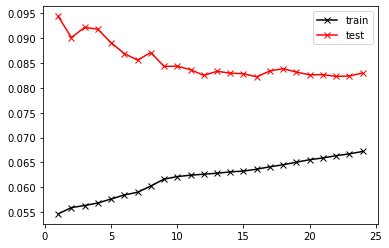

In [19]:
plt.plot(leaf_range,train_mse, '-xk',label = 'train')
plt.plot(leaf_range,test_mse,'-xr',label = 'test')
plt.legend()
plt.show()

The minimum test MSE is somewhere past 12. While the absolute minimum is at 16, there is little variance once this number is sufficiently large. The answer (4, 19) is in this range, and is the most accurate answer.

## Q6

From the last question, we can assume that the ideal decision tree has a max depth of 4 and a minimum samples per leaf of 19. Using these hyperparameters for our decision tree regressor, we can create a confusion matrix for each fold of our k-fold validation. By adding up the false negatives in each fold, we will have our total number of false negatives.

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier as DTC

In [27]:
model = DTC(random_state = 12345, max_depth = 4, min_samples_leaf = 19)
kf = KFold(n_splits=10, random_state=12345,shuffle=True)

for train_index, test_index in kf.split(X):
    X_train = X.values[train_index]
    y_train = y[train_index]
    X_test = X.values[test_index]
    y_test = y[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    print(pd.DataFrame(cm))

    0   1
0  16   0
1   2  39
    0   1
0  19   7
1   6  25
    0   1
0  17   1
1   5  34
    0   1
0  12   2
1   4  39
    0   1
0  24   4
1   3  26
    0   1
0  19   2
1   4  32
    0   1
0  16   2
1   3  36
    0   1
0  23   1
1   2  31
    0   1
0  22   2
1   2  31
    0   1
0  18   5
1   3  30


A false negative is where the prediction is benign (1), but the actual case is malignant (0). These are stored in the bottom left of each matrix. Adding these up will give us the total false negatives.

In [28]:
sum_fn = 2 + 6 + 5 + 4 + 3 + 4 + 3 + 2 + 2 + 3
sum_fn

34

Our sum is 34. The closest answer choice is 32.

## Q7

In [30]:
# We can use largely the same code from Q5, but store the accuracy
train = []
test = []

for i in depth_range:
    dtr = DTR(max_depth = 4, min_samples_leaf = 19, random_state = 1693)
    tr,te,msetr,msete = DoKFold(dtr, X, y, 10)
    train.append(np.mean(tr))
    test.append(np.mean(te))

In [31]:
test

[0.6354045287111109,
 0.6354045287111109,
 0.6354045287111109,
 0.6354045287111109,
 0.6354045287111109,
 0.6354045287111109,
 0.6354045287111109,
 0.6354045287111109,
 0.6354045287111109]

Our mean accuracy is 63.5%. This is closest to answer choice 70%.

## Q8

This is the definition of a hyperparameter.

## Q9

The decision to use regressors or classifiers is one example of a case where one must consider whether the data is discrete or continuous. While a linear model may work well for linear data, a decision tree may work best for non-linear data. Both answer choices influence what the most apropriate model is.

## Q10

As a rule of thumb, parsimonious models (those with fewer variables and/or inputs) are preferable over non-parsimonious models, as they are more intuitive and less prone to overfitting.

## Q11

This is the definition of PCA. It is used to preserve the variance of an input while reducing the number of variables (in most cases).

## Q12

In [67]:
# We want to use all of the variables now
data = lbc()
X = pd.DataFrame(data = data.data, columns = data.feature_names)
y = data.target
# They have to be scaled
Xs = scale.fit_transform(X)

In [68]:
from sklearn.decomposition import PCA

In [69]:
pca = PCA(n_components = 9)
pca.fit(Xs)

PCA(n_components=9)

In [70]:
model = DTC(random_state = 1234, max_depth = 10, min_samples_leaf = 20)
model.fit(Xs, y)
y_pred = model.predict(Xs)
cm = confusion_matrix(y, y_pred)
print(pd.DataFrame(cm))

     0    1
0  201   11
1   13  344


True positives occur when both the real and predicted value is 0. There are 201 of these in the dataset. This is closest to answer choice 196.